<a href="https://colab.research.google.com/github/Aravinda89/Image-Classificatio-from-Scratch/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install fastai==2.0.15
# !pip install fastai2==0.0.30
# !pip install fastcore==1.0.16
# !pip install fastai --upgrade

! [ -e /content ] && pip install -Uqq fastai 


     |████████████████████████████████| 189 kB 5.1 MB/s 
     |████████████████████████████████| 56 kB 2.5 MB/s 


In [ ]:
# !pip install --upgrade git+https://github.com/fastai/fastai.git

In [65]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [2]:
from fastai.vision.all import *

In [3]:
from torch import nn

from fastai.callback.hook import summary
from fastai.callback.schedule import fit_one_cycle, lr_find 
from fastai.callback.progress import ProgressCallback

from fastai.data.core import Datasets, DataLoaders, show_at
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import Categorize, GrandparentSplitter, parent_label, ToTensor, IntToFloatTensor, Normalize

from fastai.layers import Flatten
from fastai.learner import Learner

from fastai.metrics import accuracy, CrossEntropyLossFlat

from fastai.vision.augment import CropPad, RandomCrop, PadMode
from fastai.vision.core import PILImageBW
from fastai.vision.utils import get_image_files

In [4]:
# Load data
path = untar_data(URLs.MNIST)

In [5]:
items = get_image_files(path)

In [6]:
items[0]

Path('/root/.fastai/data/mnist_png/testing/1/9923.png')

In [7]:
items[:3]

(#3) [Path('/root/.fastai/data/mnist_png/testing/1/9923.png'),Path('/root/.fastai/data/mnist_png/testing/1/3433.png'),Path('/root/.fastai/data/mnist_png/testing/1/6224.png')]

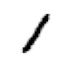

In [9]:
# Visualize image
im = PILImageBW.create(items[0])
im.show()

In [10]:
# Split train/test set
splits = GrandparentSplitter(train_name='training', valid_name='testing')

In [11]:
splits = splits(items)

In [12]:
splits[0][:5]

[10000, 10001, 10002, 10003, 10004]

In [13]:
len(splits[0])

60000

In [14]:
len(splits[1])

10000

In [15]:
dsrc = Datasets(items, tfms=[[PILImageBW.create], [parent_label, Categorize]], 
                  splits=splits)

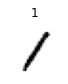

In [16]:
show_at(dsrc.train,5)

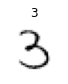

In [17]:
show_at(dsrc.valid,5000)

In [18]:
tfms = [ToTensor(), CropPad(size=34, pad_mode=PadMode.Zeros), RandomCrop(size=28)]

In [19]:
gpu_tfms = [IntToFloatTensor(), Normalize()]

In [20]:
dls = dsrc.dataloaders(bs=128, after_item=tfms, after_batch=gpu_tfms)

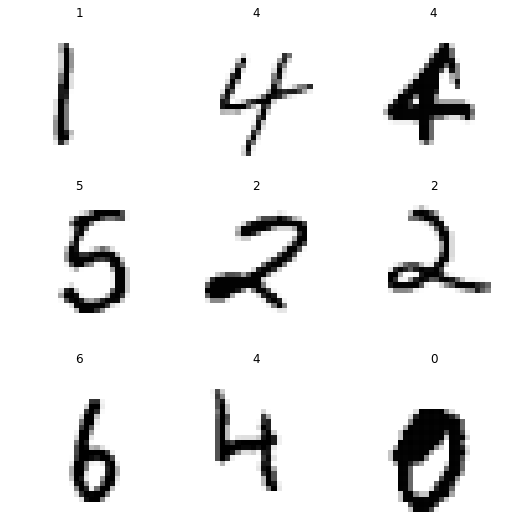

In [21]:
dls.show_batch()

In [22]:
xb, yb = dls.one_batch()

In [23]:
xb.shape, yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [24]:
dls.c

10

Model

In [25]:
def conv(ni, nf): 
  return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [26]:
def bn(nf): 
  return nn.BatchNorm2d(nf)

In [27]:
def ReLU(): 
  return nn.ReLU(inplace=False)

In [28]:
model = nn.Sequential(
                      conv(1, 8),
                      bn(8),
                      ReLU(),
                      conv(8, 16),
                      bn(16),
                      ReLU(),
                      conv(16,32),
                      bn(32),
                      ReLU(),
                      conv(32, 16),
                      bn(16),
                      ReLU(),
                      conv(16, 10),
                      bn(10),
                      Flatten()
)

In [29]:
model

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): Flatten(full=False)
)

In [30]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [31]:
learn.summary()

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 8 x 14 x 14   
Conv2d                                    80         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 7 x 7    
Conv2d                                    1168       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 4 x 4    
Conv2d                                    4640       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________

Learning Rate finder

SuggestedLRs(valley=0.007585775572806597)

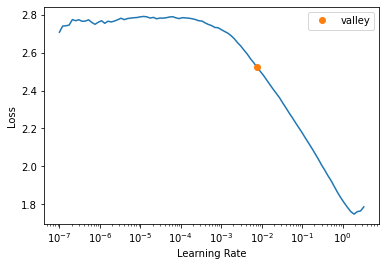

In [32]:
learn.lr_find()

In [33]:
learn.fit_one_cycle(3, lr_max=0.007585775572806597)

epoch,train_loss,valid_loss,accuracy,time
0,0.223356,0.102135,0.975900,02:02
1,0.106188,0.082468,0.977100,02:01
2,0.070597,0.046878,0.987400,02:01


In [36]:
learn.fit_one_cycle(5, lr_max=0.007585775572806597, cbs=EarlyStoppingCallback(monitor='accuracy', 
                                                                             min_delta=0.1,
                                                                             patience=2))

epoch,train_loss,valid_loss,accuracy,time
0,0.112768,0.070477,0.980400,02:01
1,0.097031,0.053011,0.983600,02:01
2,0.075611,0.048841,0.985800,02:01


No improvement since epoch 0: early stopping


Simplify

In [38]:
def conv2(ni, nf): 
  return ConvLayer(ni, nf, stride=2)

In [39]:
net = nn.Sequential(
                    conv2(1,8),
                    conv2(8,16),
                    conv2(16,32),
                    conv2(32,16),
                    conv2(16,10),
                    Flatten()
)

In [40]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

In [41]:
learn.summary()

Sequential (Input shape: 128 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     128 x 8 x 14 x 14   
Conv2d                                    72         True      
BatchNorm2d                               16         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 16 x 7 x 7    
Conv2d                                    1152       True      
BatchNorm2d                               32         True      
ReLU                                                           
____________________________________________________________________________
                     128 x 32 x 4 x 4    
Conv2d                                    4608       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________

SuggestedLRs(valley=0.010964781977236271)

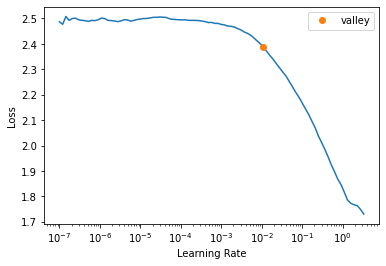

In [42]:
learn.lr_find()

In [43]:
learn.fit_one_cycle(10, lr_max=0.010964781977236271, cbs=EarlyStoppingCallback(monitor='valid_loss', 
                                                                             min_delta=0.01,
                                                                             patience=3))

epoch,train_loss,valid_loss,accuracy,time
0,0.492034,0.272352,0.953100,02:01
1,0.177863,0.113493,0.967900,02:00
2,0.137520,0.072422,0.976900,02:01
3,0.108060,0.062767,0.981200,02:01


No improvement since epoch 1: early stopping


ResNet (kinda)

In [52]:
class ResBlock(Module):
  def __init__(self, nf):
    self.conv1 = ConvLayer(nf, nf)
    self.conv2 = ConvLayer(nf, nf)
  
  def forward(self, x): 
    return x + self.conv2(self.conv1(x))

In [54]:
net = nn.Sequential(
                    conv2(1,8),
                    ResBlock(8),
                    conv2(8,16),
                    ResBlock(16),
                    conv2(16,32),
                    ResBlock(32),
                    conv2(32,16),
                    ResBlock(16),
                    conv2(16,10),
                    Flatten())

In [56]:
net

Sequential(
  (0): ConvLayer(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): ConvLayer(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (2): ConvLayer(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): ResBlock(
    (conv1): ConvLayer(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride

In [58]:
def conv_and_res(ni, nf): 
  return nn.Sequential(conv2(ni, nf), ResBlock(nf))

In [59]:
net = nn.Sequential(
    conv_and_res(1,8),
    conv_and_res(8,16),
    conv_and_res(16,32),
    conv_and_res(32,16),
    conv2(16,10),
    Flatten()
)

In [60]:
learn = Learner(dls, net, loss_func=CrossEntropyLossFlat(), metrics=[error_rate, accuracy])

SuggestedLRs(valley=0.0020892962347716093)

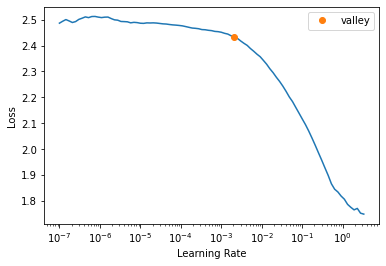

In [61]:
learn.lr_find()

In [64]:
learn.fit_one_cycle(10, lr_max=0.0020892962347716093, 
                    cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3),
                    ReduceLROnPlateau(monitor='valid_loss', patience=2)])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,1.010286,0.623953,0.109600,0.890400,02:07
1,0.255544,0.161249,0.028600,0.971400,02:06
2,0.136963,0.100981,0.027500,0.972500,02:06
3,0.095703,0.048594,0.013200,0.986800,02:06
4,0.075576,0.047581,0.012500,0.987500,02:06
5,0.055577,0.036375,0.011300,0.988700,02:06
6,0.049436,0.034534,0.010200,0.989800,02:05
7,0.041099,0.026106,0.008000,0.992000,02:06
8,0.039730,0.024260,0.006700,0.993300,02:07
9,0.030129,0.023023,0.006500,0.993500,02:07


In [66]:
learn.export('/content/gdrive/MyDrive/models/MNIST.pkl')

In [67]:
interp = ClassificationInterpretation.from_learner(learn)

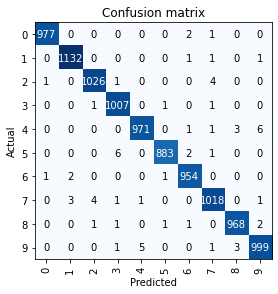

In [68]:
interp.plot_confusion_matrix()

In [73]:
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

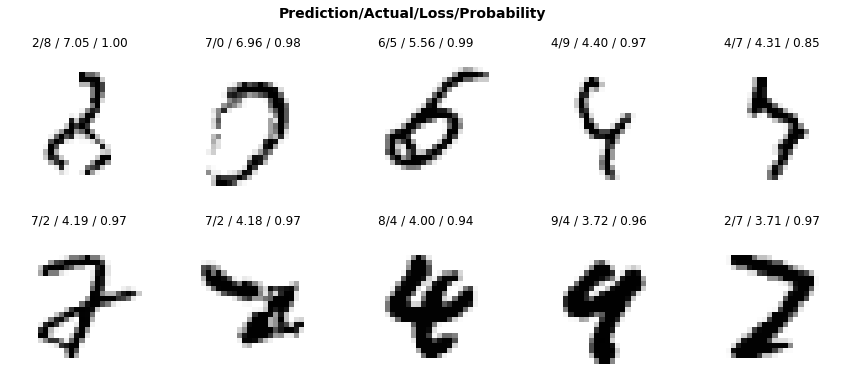

In [76]:
plot_top_losses_fix(interp, 10, nrows=2)